In [20]:
import time
import numpy as np
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

import cv2
import mediapipe as mp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [45]:
#minimum working example
cap = cv2.VideoCapture(1)

#Define mediapipe tracking instance, and drawing utility
mpHands = mp.solutions.hands
hands = mpHands.Hands(static_image_mode = False,
                                        max_num_hands = 2,
                                        min_detection_confidence = 0.3,
                                        min_tracking_confidence = 0.3, #tracking confidence will allow for the same hand to be tracked throughout
                                        model_complexity = 1)
mpDraw = mp.solutions.drawing_utils


#setup calc for frame_rate calculation
# 1 / (current time - previous time)
pTime = 0   
cTime = 0
hand_dict_res =  pd.DataFrame(columns=['handIndex',"hand_label",'timestamp','finger', 'x', 'y'])
#Start live stream from webcam
while True:
    success, img = cap.read()#get the frame
    #Try to improve performance 
    img.flags.writeable = False
    #convert image to RGB, mediapipe only takes rgb images
    imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #get detection,tracking results 
    results = hands.process(imgRGB)
    img.flags.writeable = True
     #check if a hand is detected
    if results.multi_hand_landmarks:
        #iterate over each hand and extract landmark information
        for handLms in results.multi_hand_landmarks:
            #get the hand_index and label
            handIndex = results.multi_hand_landmarks.index(handLms)
            hand_label = results.multi_handedness[handIndex].classification[0].label
            #get finger index and finger landmarks per hand
            for id,lm in enumerate(handLms.landmark):
                #get image size to get the center of the landmarks in pixels
                h,w,c = img.shape
                cx,cy = int(lm.x*w),int(lm.y*h) 
                #get a particular landmark 
                if id == 8 or id == 12:
                    cv2.circle(img, (cx,cy),15,(255,0,0),cv2.FILLED)
                    row_dict = {"handIndex":handIndex,
                        "hand_label" : hand_label,
                        "timestamp": time.time(),
                        "finger": id,
                        'x': cx,
                        'y':cy}
                    hand_dict_res = hand_dict_res.append(row_dict, ignore_index=True)
            #drawn the hand landmarks and connections onto the img
            mpDraw.draw_landmarks(img,handLms,mpHands.HAND_CONNECTIONS) 
            
    #frame rate calc
    cTime = time.time()
    fps = 1/(cTime - pTime)
    pTime = cTime
    #write the fps to ima
    cv2.putText(img=img, 
                text = str(int(fps)),
                org =(10,70),
                fontFace = cv2.FONT_HERSHEY_PLAIN,
                fontScale = 2,
                color = (255,0,255), 
                thickness = 2) 


    cv2.imshow("Webcam",img)
    if cv2.waitKey(1) & 0xFF==ord('q'): # quit when 'q' is pressed
       cap.release()
       break
    
cv2.destroyAllWindows() 

<AxesSubplot: xlabel='timestamp', ylabel='y'>

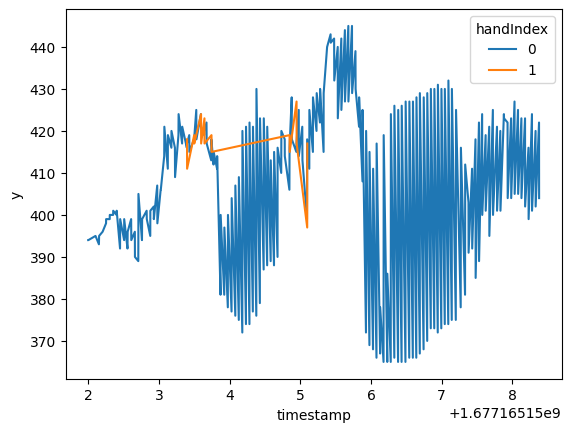

In [46]:
sns.lineplot(x='timestamp',y='y', data=hand_dict_res,hue='handIndex')

In [35]:
hand_dict_res.hand.unique()

array([0, 1], dtype=object)